In [2]:
import pandas as pd
from scipy.stats import shapiro, normaltest, anderson, levene, bartlett
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter # Import the formatter
import matplotlib as mpl
from scipy import stats
import re
import pulp
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable, LpMinimize, value,LpSolverDefault,makeDict

#### Datasets

1. Normality test and Difference in variance test.
The dataset is 1 year weekly historical demand

The dataset has the following columns and span 1 year period:
* item: anonymized item label
* date: weekly demand week
* category: consumption or forecast
* qty: weekly demand quantity

2. Dataset for safety stock analysis

The dataset is in two parts. One for the traditional safety stock approach which only has 1 year weekly historical demand quantities and another for the proposed approach which in addition to 1 year weekly historical demand has 6 month future forecasted demand as specified according to section 3.3

Both dataset has the following columns:
* item: anonymized item label
* date: weekly demand week
* class: item priority class
* fcstt_WITHIN: item forecast weight (used to determine weights in the linear program)
* price: per unit price of item

In [26]:
#read dataset for normality and variance tests
df_fcst_cons_hist = pd.read_csv("../data/paper_linear_pg/historical_forecast_consumption_small.csv",parse_dates=["date"] )

##datasets for safety stock analysis
#data for traditional safety stock dimensioning(i.e only historcal consumption without future forecast)
df_sim_optim_norm = pd.read_csv("../data/paper_linear_pg/simulation_optimization_norm.csv",parse_dates=["date"] )


#data for proposed analytical approach (i.e contenation of historical consumption and future forecast)
df_sim_optim = pd.read_csv("../data/paper_linear_pg/simulation_optimization.csv",parse_dates=["date"] )


print("historical:",)
print(df_fcst_cons_hist.head())
print("analysis_kde:", )
print(df_sim_optim.head())
print("analysis_normal:", )
print(df_sim_optim_norm.head())


historical:
      item       date     category   qty
0   item_1 2025-06-30  consumption    20
1  item_14 2024-11-25     forecast   211
2   item_1 2024-10-21     forecast  3280
3   item_2 2024-12-23  consumption    70
4   item_3 2025-01-20  consumption    61
analysis_kde:
      item       date  qty  lt_wk    price class  ttlfcst_WITHIN
0  item_10 2025-03-09  152     21  185.286     B           10337
1  item_10 2025-04-06  107     21  185.286     B           10337
2  item_10 2025-03-24  523     21  185.286     B           10337
3  item_10 2025-07-06  489     21  185.286     B           10337
4  item_10 2025-01-27   86     21  185.286     B           10337
analysis_normal:
      item       date  qty  lt_wk    price class  ttlfcst_WITHIN
0  item_10 2025-01-26   70     21  185.286     B           10337
1  item_10 2025-05-12  140     21  185.286     B           10337
2  item_10 2025-05-04  202     21  185.286     B           10337
3  item_10 2025-07-06  120     21  185.286     B           10

### Methodology
#### 3.2 Test of Normality

#### Test of normality

In [12]:
def normality_tests_by_item(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    
    for item, group in df.groupby('item'):
        qty = group['qty'].dropna()
        n = len(qty)

        # Initialize defaults
        shapiro_stat = shapiro_p = dago_stat = dago_p = None
        anderson_stat = None
        normality_shapiro = normality_dago = normality_anderson = 'insufficient data'

        if n >= 3:
            # --- Shapiro–Wilk ---
            shapiro_stat, shapiro_p = shapiro(qty)
            normality_shapiro = 'normal' if shapiro_p > 0.05 else 'not normal'

        if n >= 8:  # D’Agostino needs a bit more data
            # --- D’Agostino’s K² ---
            dago_stat, dago_p = normaltest(qty)
            normality_dago = 'normal' if dago_p > 0.05 else 'not normal'

        if n >= 3:
            # --- Anderson–Darling ---
            anderson_res = anderson(qty)
            anderson_stat = anderson_res.statistic
            # Compare to critical value at 5% significance
            crit_val = anderson_res.critical_values[2]
            normality_anderson = 'normal' if anderson_stat < crit_val else 'not normal'

        results.append({
            'item': item,
            'test_stat_shapiro': round(shapiro_stat,4),
            'test_stat_dagostino':  round(dago_stat,4),
            'test_stat_anderson':  round(anderson_stat,4),
            'critical_val_anderson':  round(crit_val,4),
            'p_value_shapiro':  round(shapiro_p,4),
            'p_value_dagostino':  round(dago_p,4),
             'normality_shapiro': normality_shapiro,
            'normality_anderson': normality_anderson,
            'normality_dagostino': normality_dago,

        })
    
    return pd.DataFrame(results)

In [13]:
norm_test_results = (normality_tests_by_item(df = df_fcst_cons_hist.loc[(df_fcst_cons_hist["category"]=='consumption'),
                                                                        ["item","qty"]])
                    .sort_values("item",
                                 ascending=True,
                                 key=lambda x: x.str[len("item_"):].astype(int)))
norm_test_results

,item,test_stat_shapiro,test_stat_dagostino,test_stat_anderson,critical_val_anderson,p_value_shapiro,p_value_dagostino,normality_shapiro,normality_anderson,normality_dagostino
0,item_1,0.7526,63.4327,6.5114,0.757,0.0000,0.0000,not normal,not normal,not normal
11,item_2,0.6921,87.5753,7.4018,0.757,0.0000,0.0000,not normal,not normal,not normal
13,item_3,0.6549,68.9287,11.1566,0.757,0.0000,0.0000,not normal,not normal,not normal
14,item_4,0.6383,47.8420,14.2743,0.757,0.0000,0.0000,not normal,not normal,not normal
15,item_5,0.7555,64.7675,6.1910,0.757,0.0000,0.0000,not normal,not normal,not normal
16,item_6,0.8439,38.2721,3.8817,0.757,0.0000,0.0000,not normal,not normal,not normal
17,item_7,0.6164,41.8415,10.1543,0.746,0.0000,0.0000,not normal,not normal,not normal
18,item_8,0.9523,8.4923,1.0712,0.757,0.0015,0.0143,not normal,not normal,not normal
19,item_9,0.7802,54.1709,6.1399,0.757,0.0000,0.0000,not normal,not normal,not normal
1,item_10,0.9037,21.5181,2.7946,0.757,0.0000,0.0000,not normal,not normal,not normal


#### Differences in variance test

In [17]:
def variance_tests_by_item(df: pd.DataFrame) -> pd.DataFrame:
    results = []

    for item, group in df.groupby('item'):
        # Split by category
        forecast = group.loc[group['category'] == 'forecast', 'qty'].dropna()
        consumption = group.loc[group['category'] == 'consumption', 'qty'].dropna()

        if len(forecast) < 2 or len(consumption) < 2:
            results.append({
                'item': item,
                'levene_stat': None,
                'levene_p': None,
                'levene_result': 'insufficient data',
                'bartlett_stat': None,
                'bartlett_p': None,
                'bartlett_result': 'insufficient data'
            })
            continue

        # --- Levene’s Test (robust to non-normality)
        lev_stat, lev_p = levene(forecast, consumption, center='median')
        lev_result = 'significant difference' if lev_p < 0.05 else 'no significant difference'

        # --- Bartlett’s Test (assumes normality)
        bart_stat, bart_p = bartlett(forecast, consumption)
        bart_result = 'significant difference' if bart_p < 0.05 else 'no significant difference'

        results.append({
            'item': item,
            'levene_stat': round(lev_stat,4),
            'levene_p': round(lev_p,4),
            'levene_result':lev_result,
            'bartlett_stat': round(bart_stat,4),
            'bartlett_p': round(bart_p,4),
            'bartlett_result': bart_result
        })

    return pd.DataFrame(results)


In [18]:
var_test_result = (variance_tests_by_item(df = df_fcst_cons_hist[["item","qty", "category"]])
                   .sort_values("item",
                                ascending=True,
                                key=lambda x: x.str[len("item_"):].astype(int)))
var_test_result

,item,levene_stat,levene_p,levene_result,bartlett_stat,bartlett_p,bartlett_result
0,item_1,18.9794,0.0000,significant difference,310.0217,0.0000,significant difference
11,item_2,20.6629,0.0000,significant difference,94.8292,0.0000,significant difference
13,item_3,22.0937,0.0000,significant difference,93.7873,0.0000,significant difference
14,item_4,15.3496,0.0001,significant difference,58.4140,0.0000,significant difference
15,item_5,21.5314,0.0000,significant difference,117.0549,0.0000,significant difference
16,item_6,22.9283,0.0000,significant difference,106.4554,0.0000,significant difference
17,item_7,21.0464,0.0000,significant difference,210.8867,0.0000,significant difference
18,item_8,31.4594,0.0000,significant difference,202.2580,0.0000,significant difference
19,item_9,22.5487,0.0000,significant difference,76.6868,0.0000,significant difference
1,item_10,26.6831,0.0000,significant difference,144.6490,0.0000,significant difference


### Analysis
Distribution Fitting, Simulation, Optimization

In [28]:
### Function to prepare the data for simulation
def data_prep(df,
              service_lvl_alpha:list=[0.0,0.5,0.55,0.6,0.65,0.70,0.75,0.8,0.85, 0.9,0.95,0.99], 
              review_periods:list=[4]):
    '''
    Description:
        Returns a transformed dataframe with service level inputs and review period
    Inputs: 
        df:pd.DataFrame: dataframe to transform
        service_lvl_alpha: list. List of desired service level alphas
        review_periods: list. List of desired safety stock review periods
    output:
        tuple of dataframes
    
    '''

    #transform the data adding std
    df_gp = df.groupby(["item"]).agg(d_std=("qty",lambda x: np.round(np.std(x,ddof=1),4)),
                                  d_mu=("qty",lambda x:np.round(np.mean(x),0)),
                                  lt_wk=("lt_wk","max"),
                                  price =("price","max")).reset_index()
                                  
    
    #service levels added as column
    alphas = service_lvl_alpha
    for alpha in alphas:
        df_gp[f'SL_{round(100*alpha)}'] = alpha
    df_gp = pd.melt(df_gp, 
                    id_vars=['item', 'd_std', 'd_mu', 'lt_wk', 'price']).rename(columns = {"variable":"SL_label", "value":"SL_value"})

    #Review periods
    r_periods = review_periods
    for period in r_periods:
        df_gp[f'R_{period}WK'] = period
    df_gp = pd.melt(df_gp, 
                id_vars=['item', 'd_std', 'd_mu', 
                         'lt_wk', 'price', 'SL_label', 'SL_value']).rename(columns = {"variable":"R_label", "value":"R_value"})


    return df_gp

In [20]:
## Funciton to estimate kernel density and convert to probability mass functions
def fit_discrete_kde(d_x, bw_method='scott', cut=3, support_min=0):
    """
    Fit Gaussian KDE to data d_x, evaluate on integer grid, and return a discrete PMF.
    Probability mass below `support_min` is merged into the first valid bin.
    """
    d_x = np.asarray(d_x, dtype=float)

    # KDE
    kde = stats.gaussian_kde(d_x, bw_method=bw_method)

    # Bandwidth and range (inclusive)
    bandwidth = kde.factor * np.std(d_x, ddof=1)
    lower = int(np.floor(d_x.min() - cut * bandwidth))
    upper = int(np.ceil(d_x.max() + cut * bandwidth))
    if upper < lower:
        lower, upper = upper, lower
    x = np.arange(lower, upper + 1, dtype=int)

    # Evaluate and normalize to PMF (Δx = 1)
    pdf_vals = kde.pdf(x.astype(float))
    total = pdf_vals.sum()
    if total == 0:
        # Degenerate fallback: put all mass at nearest integer to mean
        xi = int(np.rint(d_x.mean()))
        return np.array([xi], dtype=int), np.array([1.0], dtype=float)
    pmf = pdf_vals / total

    # Truncate below support_min and merge spill into first valid bin
    if support_min is not None:
        mask = x >= support_min
        if not mask.any():
            # Everything is below support_min → put all mass at support_min
            return np.array([int(support_min)], dtype=int), np.array([1.0], dtype=float)

        spill = pmf[~mask].sum()
        first_idx = np.where(mask)[0][0]          # index in original arrays
        pmf[first_idx] += spill                   # add to original pmf
        # Now actually truncate arrays
        pmf = pmf[mask]
        x = x[mask]

    # Final renormalization (protect against FP drift)
    pmf = pmf / pmf.sum()

    return x.astype(int), pmf

### function to get distribution attributes
def attributes(pmf, x):
    """
    Takes discrete demand series and corresponding probability mass function and returns discrete distribution attributes

    Parameters:
    pmf (numpy array): corresponding probability mass function
    x (numpy array): discrete demand

    Returns:
    tuple: tuple of (mu: expected mean of the distribution, std: standard deviation of the distribution)
    """
    pmf = np.asarray(pmf)
    x = np.asarray(x)

    mu = np.sum(pmf * x)
    var = np.sum(pmf * (x - mu)**2)
    std = np.sqrt(var)
    return mu, std


In [21]:
# Simulation Functions

### Safety Stock Over Risk Period (L + R): Fitting Gaussian Kernel Density, simulation
def simulate_safety_kde(
    d_x, d_pmf, L=4, R=1, alpha=0.95, time=200, pu_price=None, holding_rate=1, seed=111
):
    if seed:
        np.random.seed(seed)
        
    # --- Demand distribution attributes ---
    d_mu, d_std = attributes(d_pmf, d_x)
    # print(f"mean: {d_mu} and std: {d_std}")
    d = np.random.choice(d_x, size=time, p=d_pmf)
    # print(f"demand: {d}")
    # --- Empirical safety stock based on KDE quantile ---
    period_demand_samples = np.random.choice(d_x, size=(1000, L+R), p=d_pmf)
    # print(f"sample: {period_demand_samples}")
    total_demand_LR = np.sum(period_demand_samples, axis=1)
    ss_empirical = np.quantile(total_demand_LR, alpha) - np.mean(total_demand_LR)
    ss_empirical = max(0.0, ss_empirical)
    Ss = np.round(ss_empirical).astype(int)
    # print(f"total_demand: {total_demand_LR}, ss_empirical: {ss_empirical}, ss: {Ss}")

    # --- Stock components ---
    Cs = 0.5 * d_mu * R
    Is = d_mu * L
    S = Ss + 2*Cs + Is

    # --- Cost impact ---
    S_value = round(pu_price * holding_rate * Ss,4) if pu_price else 0.0000

    # --- Inventory simulation ---
    hand = np.zeros(time)
    transit = np.zeros((time, L+1))
    stockout_period = np.full(time, False, dtype=bool)
    stockout_cycle = []

    hand[0] = S - d[0]
    transit[0, -1] = d[0]

    for t in range(1, time):
        if transit[t-1, 0] > 0:
            stockout_cycle.append(stockout_period[t-1])
        hand[t] = hand[t-1] - d[t] + transit[t-1, 0]
        stockout_period[t] = hand[t] < 0
        hand[t] = max(0, hand[t])
        transit[t, :-1] = transit[t-1, 1:]
        if t % R == 0:
            net = hand[t] + transit[t].sum()
            transit[t, L] = S - net

    df = pd.DataFrame({'Demand': d, 'On-hand': hand, 'In-transit': list(transit)})
    df = df.iloc[L+R:, :]

    # SL_cycle = round((1 - np.mean(stockout_cycle)) * 100, 1)
    # SL_period = round((1 - np.mean(stockout_period)) * 100, 1)
    SL_cycle = round((1 - np.mean(stockout_cycle)), 4)
    SL_period = round((1 - np.mean(stockout_period)), 4)
    
    return round(alpha * 100, 1), SL_cycle, SL_period, Ss, S_value

In [22]:
def simulate_safety_norm(
    d_mu, d_std, L=4, R=1, alpha=0.95, time=200, pu_price=None, holding_rate=1, seed=111
):
    if seed:
        np.random.seed(seed)
        
    d = np.maximum(np.random.normal(d_mu,d_std,time).round(0).astype(int),0)
    z = stats.norm.ppf(alpha)
    if z < 0:
        z = 0.0
    x_std = np.sqrt(L+R)*d_std
    Ss = np.round(x_std*z).astype(int)
    Ss = max(0.0, Ss)
    Cs = 1/2 * d_mu * R
    Is = d_mu * L
    S = Ss + 2*Cs + Is

    # --- Cost impact ---
    S_value = round(pu_price * holding_rate * Ss,4) if pu_price else 0

    # --- Inventory simulation ---
    hand = np.zeros(time)
    transit = np.zeros((time, L+1))
    stockout_period = np.full(time, False, dtype=bool)
    stockout_cycle = []

    hand[0] = S - d[0]
    transit[0, -1] = d[0]

    for t in range(1, time):
        if transit[t-1, 0] > 0:
            stockout_cycle.append(stockout_period[t-1])
        hand[t] = hand[t-1] - d[t] + transit[t-1, 0]
        stockout_period[t] = hand[t] < 0
        hand[t] = max(0, hand[t])
        transit[t, :-1] = transit[t-1, 1:]
        if t % R == 0:
            net = hand[t] + transit[t].sum()
            transit[t, L] = S - net

    df = pd.DataFrame({'Demand': d, 'On-hand': hand, 'In-transit': list(transit)})
    df = df.iloc[L+R:, :]

    # SL_cycle = round((1 - np.mean(stockout_cycle)) * 100, 1)
    # SL_period = round((1 - np.mean(stockout_period)) * 100, 1)
    SL_cycle = round((1 - np.mean(stockout_cycle)), 4)
    SL_period = round((1 - np.mean(stockout_period)), 4)
    
    return round(alpha * 100, 1), SL_cycle, SL_period, Ss, S_value

#### Performance analysis of Proposed method vr traditional method

In [29]:
### Transform data for simulation and optimization
##traditional approach data transform
df_sim_optim_gp_norm = data_prep(df=df_sim_optim_norm)


##kde-based approach data transform
df_sim_optim_gp = data_prep(df=df_sim_optim)

print("normal:")
print(df_sim_optim_gp_norm.head(5))
print("kde:")
print(df_sim_optim_gp.head(5))

normal:
      item     d_std   d_mu  lt_wk    price SL_label  SL_value R_label  \
0   item_1  127.6334  136.0     21  956.211     SL_0       0.0   R_4WK   
1  item_10  148.1899  226.0     21  185.286     SL_0       0.0   R_4WK   
2  item_11  303.0709  322.0     21  661.047     SL_0       0.0   R_4WK   
3  item_12   85.0771  121.0     16  112.438     SL_0       0.0   R_4WK   
4  item_13  458.0928  811.0     21  240.041     SL_0       0.0   R_4WK   

   R_value  
0        4  
1        4  
2        4  
3        4  
4        4  
kde:
      item     d_std   d_mu  lt_wk    price SL_label  SL_value R_label  \
0   item_1  263.4511  203.0     21  956.211     SL_0       0.0   R_4WK   
1  item_10  203.6807  267.0     21  185.286     SL_0       0.0   R_4WK   
2  item_11  354.6807  394.0     21  661.047     SL_0       0.0   R_4WK   
3  item_12  131.3549  150.0     16  112.438     SL_0       0.0   R_4WK   
4  item_13  707.9435  979.0     21  240.041     SL_0       0.0   R_4WK   

   R_value  
0     

In [30]:
#simulation for the traditional approach
sim_results_norm = []
for idx, row in df_sim_optim_gp_norm.iterrows():
    t_alpha, sl_cycle, sl_period, ss, ss_value = simulate_safety_norm(d_mu=row['d_mu'], 
                                d_std=row['d_std'],
                                pu_price=row['price'],
                                R=row['R_value'],
                                L=row['lt_wk'],
                                alpha=row['SL_value'], 
                                time=1000)
    sim_results_norm.append({
        "item":row["item"],
        "t_alpha":t_alpha,
        "sl_cycle":sl_cycle,
        "sl_period":sl_period,
        "ss":ss,
        "ss_value":ss_value,
    })
sim_results_norm_df = pd.DataFrame(sim_results_norm)

print("simulation - normal:")
print(sim_results_norm_df.head())

simulation - normal:
      item  t_alpha  sl_cycle  sl_period   ss  ss_value
0   item_1      0.0    0.7254      0.866  0.0       0.0
1  item_10      0.0    0.7551      0.902  0.0       0.0
2  item_11      0.0    0.7254      0.866  0.0       0.0
3  item_12      0.0    0.7236      0.893  0.0       0.0
4  item_13      0.0    0.7592      0.910  0.0       0.0


In [31]:
#simulation for the proposed kde-based approach

sim_results_kde= []
try:
    #Fit custom distributions
    #list of dictinaries of purchase group(item) and fitted demand distribution with probability mass function
    kde_li = []
    for item in df_sim_optim['item'].unique():
        try:
            d_x, d_pmf = fit_discrete_kde(df_sim_optim[df_sim_optim['item']==item]['qty'])
            kde_li.append({"item":item, "d_x":d_x,"d_pmf":d_pmf})
        #for item where there is lower subspace in data in order to fit custom distribution,skip
        except Exception as error:
            pass
    #merge the results pack to df_gp dataframe
    df_kde = df_sim_optim_gp.merge(pd.DataFrame(kde_li),
                    on="item",
                    how="left")
    # #remove instances of 'd_x' being NaN
    # df_kde = df_kde[~df_kde['d_x'].isna()]
    
    

    ### Run Simulation
    for idx, row in df_kde.iterrows():
        t_alpha, sl_cycle, sl_period, ss, ss_value =  simulate_safety_kde(d_x=row['d_x'], 
                                                    d_pmf=row['d_pmf'],
                                                    pu_price=row['price'],
                                                    R=row['R_value'],
                                                    L=row['lt_wk'],
                                                    alpha=row['SL_value'], 
                                                    time=1000)
        sim_results_kde.append({
            "item":row["item"],
            "t_alpha":t_alpha,
            "sl_cycle":sl_cycle,
            "sl_period":sl_period,
            "ss":ss,
            "ss_value":ss_value,
        })


except Exception as error:
    print(error)

sim_results_kde_df = pd.DataFrame(sim_results_kde )

print("simulation - kde:")
print(sim_results_kde_df)

simulation - kde:
        item  t_alpha  sl_cycle  sl_period    ss     ss_value
0     item_1      0.0    0.8115      0.903     0        0.000
1    item_10      0.0    0.7828      0.914     0        0.000
2    item_11      0.0    0.7869      0.914     0        0.000
3    item_12      0.0    0.7480      0.890     0        0.000
4    item_13      0.0    0.7787      0.915     0        0.000
..       ...      ...       ...        ...   ...          ...
235   item_5     99.0    1.0000      1.000  6052  1082309.420
236   item_6     99.0    0.9959      0.997  8402  1222675.844
237   item_7     99.0    1.0000      1.000  2580  1689580.080
238   item_8     99.0    1.0000      1.000  4782   726768.360
239   item_9     99.0    1.0000      0.999  1555   750875.290

[240 rows x 6 columns]


In [32]:
#concat results to visualize
sim_plot_df = sim_results_norm_df[["item","t_alpha","sl_cycle"]].merge(sim_results_kde_df[["item","t_alpha","sl_cycle"]], 
                                                          how="left",
                                                          on=["item","t_alpha"], suffixes=("_norm","_kde"))


Visualize Simulation Results

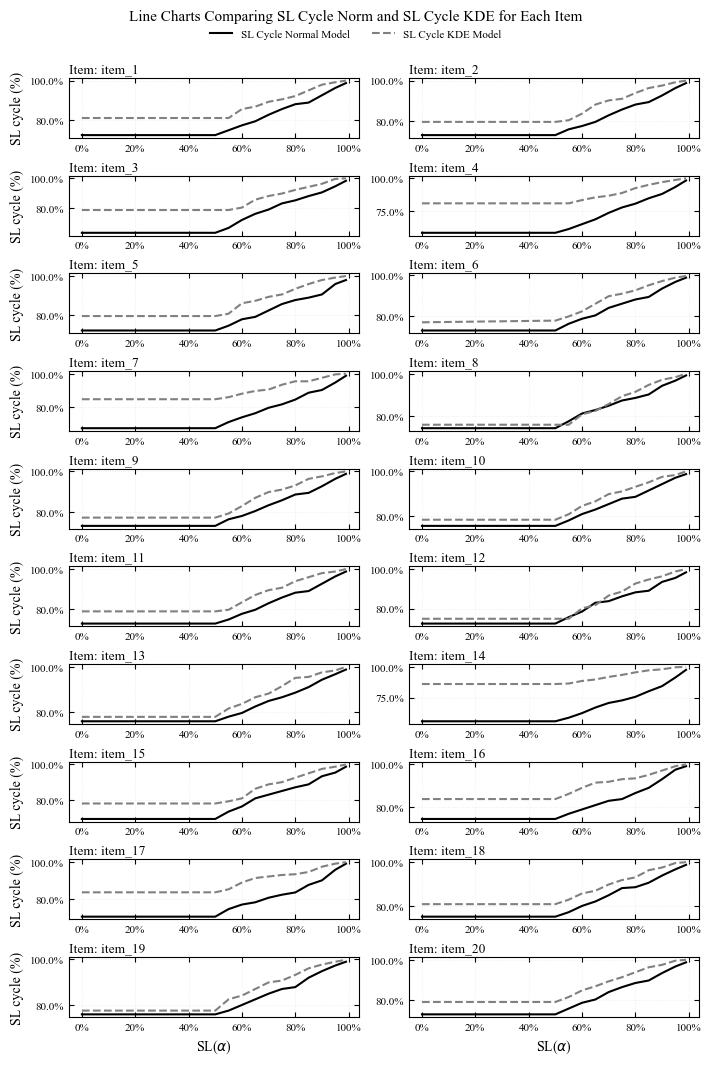

In [34]:
#visualization

num_items = sim_plot_df["item"].nunique()
data = []
for i in range(1, num_items + 1):
    t_alpha = np.arange(0, 10, 0.5)
    # Generate random data between 0 and 1
    sl_cycle_norm = (np.random.rand(len(t_alpha)) * 0.2) + (i / num_items * 0.8)
    sl_cycle_kde = (np.random.rand(len(t_alpha)) * 0.2) + (i / num_items * 0.8)
    item_df = pd.DataFrame({
        'item': f'Item {i}',
        't_alpha': t_alpha,
        'sl_cycle_norm': sl_cycle_norm,
        'sl_cycle_kde': sl_cycle_kde
    })
    data.append(item_df)
# df = pd.concat(data, ignore_index=True)
unique_items = sim_plot_df['item'].unique()
unique_items = sorted(unique_items, key=lambda x: int(re.search(r'\d+', x).group()))

# --- Best practices for INFORMS-style publication graphs ---
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 8  # Standard journal font size
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.titlesize'] = 12

# Finer control for axes and gridlines
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 0.8
mpl.rcParams['grid.color'] = 'gray'
# mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True

# 2. Determine the plot layout
num_rows = 10
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 10), constrained_layout=True)
axes = axes.flatten()

# Define high-contrast line styles suitable for both color and grayscale printing
line_styles = {
    'sl_cycle_norm': {'color': 'black', 'linestyle': '-', 'label': 'SL Cycle Normal Model'},
    'sl_cycle_kde': {'color': 'gray', 'linestyle': '--', 'label': 'SL Cycle KDE Model'}
}

# 3. Loop and plot for each item with publication-ready styling
for i, item in enumerate(unique_items):
    item_data = sim_plot_df[sim_plot_df['item'] == item]
    ax = axes[i]
    
    # Plot with distinct line styles for readability in grayscale
    ax.plot(item_data['t_alpha'], item_data['sl_cycle_norm'], **line_styles['sl_cycle_norm'])
    ax.plot(item_data['t_alpha'], item_data['sl_cycle_kde'], **line_styles['sl_cycle_kde'])
    
    # Set the title and labels for the subplot
    ax.set_title(f"Item: {item}", loc='left', pad=4)
    ax.tick_params(direction='in', top=True, right=True)
    
    # Set axis labels, only showing them on the outer plots
    if i % num_cols == 0:
        ax.set_ylabel('SL cycle (%)') # Updated y-label to reflect percentage
    if i >= num_items - num_cols:
        ax.set_xlabel('SL($\\alpha$)')

    # Add a minimalist grid
    ax.grid(True, linestyle=':', alpha=0.5, color='lightgray')

# 4. Format the y-axis as a percentage for all subplots
for ax in axes:
    # Use PercentFormatter. xmax=1.0 scales data from 0-1 to 0-100%.
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))

# Remove any unused subplots
for j in range(len(unique_items), num_rows * num_cols):
    fig.delaxes(axes[j])

# Place a single combined legend outside the plot area
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, frameon=False)
fig.suptitle('Line Charts Comparing SL Cycle Norm and SL Cycle KDE for Each Item', fontsize=11, y=1.05)


plt.show()

Optimization

In [35]:
# Function for linear optimization model
def run_lp(df, tolerance_level=0.01):
    #data prep
    df = df
    # df["sl_alpha"] = df["sl_alpha"]/100
    
    df_grp = df.groupby(["class","item","SL_value"]).agg(sl_alpha_avg =("sl_alpha","mean"),
                                                 sl_total_value =('ss_total_value',"sum"), 
                                                 sl_period_avg =("sl_period","mean"),
                                                ss=('ss',"sum")).reset_index()

    

    items = df['item'].unique().tolist()
    sl_values = df["SL_value"].unique().tolist()
    classes = df["class"].unique().tolist()

    #def linear problem
    prob = LpProblem("service_level",LpMinimize)

    #decision variables
    item_var = LpVariable.dicts("item_Srvc_lvl", (items, sl_values), cat="Binary")

    #objective function
    prob += lpSum(item_var[item][sl_value] * df_grp.loc[((df_grp["item"] ==item) & (df_grp["SL_value"]==sl_value)),"sl_total_value" ].iloc[0] for sl_value in sl_values for item in items)

   
    #constraint 1
    #ttlfcst_within_agg
    df_ttfcst_within = df[df["SL_value"]==0.7].groupby(["item"]).agg(ttlfcst_within_agg = ("ttlfcst_WITHIN","sum")).reset_index()
    df_c = df.merge(df_ttfcst_within,how="left", on="item")

    #ttlfcst_grp_agg
    df_ttfcst_grp = df[df["SL_value"]==0.7].groupby(["class"]).agg(ttlfcst_grp_agg = ("ttlfcst_WITHIN","sum")).reset_index()
    df_c = df_c.merge(df_ttfcst_grp,how="left", on="class")

    #ttlfcst_within_prob
    df_c["ttlfcst_within_prob"] = df_c["ttlfcst_within_agg"] /  df_c["ttlfcst_grp_agg"]


    
    # Loop through each unique class
    #formulate the weighted constraint

    for cls in classes:
        ls_class_A = []
        ls_class_B = []
        ls_class = []
        
        # Filter dataframes for current zeinr
        df_grp_temp = df_grp.loc[df_grp["class"] == cls]
        df_c_temp = df_c.loc[df_c["class"] == cls]
        
        # Get unique item and sl_values for current zeinr
        item_ids = df_grp_temp["item"].unique().tolist()
        sl_vals = df_grp_temp["SL_value"].unique().tolist()
        
        # Loop through each items

        for item in item_ids:
            # Calculate the list of expressions for the current item and sl_value
            ls = [item_var[item][sl_value] * 
                  df_grp_temp.loc[((df_grp_temp["item"] == item) & (df_grp_temp["SL_value"] == sl_value)), "sl_alpha_avg"].iloc[0] * 
                  df_c_temp.loc[((df_c_temp["item"] == item) & (df_c_temp["SL_value"] == sl_value)), "ttlfcst_within_prob"].iloc[0]
                  for sl_value in sl_vals]

            # Add the calculated expressions to the list for the current zeinr
            
            if cls.endswith("_A"):
                ls_class_A.append(ls)
            elif cls.endswith("_B"):
                ls_class_B.append(ls)
            else:
                ls_class.append(ls)

        # Add the constraint to the problem
        if len(ls_class) > 0:
            prob += lpSum(ls_class) >= 0.95
        if len(ls_class_A) > 0:
            prob += lpSum(ls_class_A) >= 0.95 #changed  from 0.90
        if len(ls_class_B) > 0:
            prob += lpSum(ls_class_B) >= 0.90 #changed from 0.90


    #reget lists
    items = df['item'].unique().tolist()
    sl_values = df["SL_value"].unique().tolist()
    classes = df["class"].unique().tolist()     
    
    #constraint 2
    for item in items:
        prob +=lpSum([item_var[item][sl_value] for sl_value in sl_values]) == 1

    
    lp_status = prob.solve(pulp.PULP_CBC_CMD(gapRel=0.0,msg=False))
 
    if lp_status == 1:
        #get optimal sl_values
        optimal_solution = []
        for item in items:
            for sl_value in sl_values:
                if item_var[item][sl_value].value() > 0:
                    optimal_solution.append({"item":item, "sl_value":sl_value})
        
        results_df = pd.DataFrame(optimal_solution)

        # merge with ttlfcst
        results_df = results_df.merge(df_c[['item','SL_value','ttlfcst_within_prob']], 
                      left_on=["item","sl_value"], right_on=["item","SL_value"],
                      how = "left")
        results_df  = results_df[["item","sl_value","ttlfcst_within_prob"]]

        results_df = pd.merge(results_df,
                              df_grp,how="left",
                              left_on=["item","sl_value"],
                              right_on=["item","SL_value"])[["item","class",
                                                              "ss","sl_value", "sl_alpha_avg", "sl_period_avg",
                                                              "sl_total_value","ttlfcst_within_prob"]]
        results_df['lp_status'] = LpStatus[prob.status]
        results_df['objective_value'] = np.round(prob.objective.value(),2)                           

        return results_df, np.round(prob.objective.value(),2)
    else:
        raise Exception(LpStatus[prob.status])

In [36]:
try:
    #Fit custom distributions
    #list of dictinaries of purchase group(item) and fitted demand distribution with probability mass function
    kde_li = []
    for item in df_sim_optim['item'].unique():
        try:
            d_x, d_pmf = fit_discrete_kde(df_sim_optim[df_sim_optim['item']==item]['qty'])
            kde_li.append({"item":item, "d_x":d_x,"d_pmf":d_pmf})
        #for item where there is lower subspace in data in order to fit custom distribution,skip
        except Exception as error:
            pass
    #merge the results pack to df_gp dataframe
    df_kde = df_sim_optim_gp.merge(pd.DataFrame(kde_li),
                    on="item",
                    how="left")
    # #remove instances of 'd_x' being NaN
    # df_kde = df_kde[~df_kde['d_x'].isna()]
    
    
    print("custom fitting successful") #must delete

    ### Run Simulation

    chunk_df = df_kde.copy()
    chunk_df['result'] =  chunk_df.apply(lambda x: simulate_safety_kde(d_x=x['d_x'], 
                                                                                d_pmf=x['d_pmf'],
                                                                                pu_price=x['price'],
                                                                                R=x['R_value'],
                                                                                L=x['lt_wk'],
                                                                                alpha=x['SL_value'], 
                                                                                time=1000),
                                        axis=1)
    chunk_df[["t_alpha", "sl_alpha", "sl_period", "ss", "ss_value"]] = pd.DataFrame(chunk_df['result'].tolist(),index=chunk_df.index)
    chunk_df.drop(columns=['result', 'd_x','d_pmf'],inplace=True)
    #set simulation status flag to True
    simulation_status = True
    print("simulation completed") #must delete
except Exception as error:
    print(error)


custom fitting successful
simulation completed


In [37]:
try:

    chunk_df_norm = df_sim_optim_gp_norm.copy()
    chunk_df_norm['result'] =  chunk_df_norm.apply(lambda x: simulate_safety_norm(d_mu=x['d_mu'], 
                                                                                d_std=x['d_std'],
                                                                                pu_price=x['price'],
                                                                                R=x['R_value'],
                                                                                L=x['lt_wk'],
                                                                                alpha=x['SL_value'], 
                                                                                time=1000),
                                        axis=1)
    chunk_df_norm[["t_alpha", "sl_alpha", "sl_period", "ss", "ss_value"]] = pd.DataFrame(chunk_df_norm['result'].tolist(),index=chunk_df_norm.index)
    chunk_df_norm.drop(columns=['result'],inplace=True)
    #set simulation status flag to True
    simulation_status = True
    print("simulation completed") #must delete
except Exception as error:
    print(error)


simulation completed


In [38]:
df_lp = chunk_df.merge(df_sim_optim[["item","class","ttlfcst_WITHIN",]].drop_duplicates(), on="item", how="inner" )
df_lp["ss_total_value"] = df_lp["price"] * df_lp["ss"] 


df_lp_norm = chunk_df_norm.merge(df_sim_optim[["item","class","ttlfcst_WITHIN"]].drop_duplicates(), on="item", how="inner" )
df_lp_norm["ss_total_value"] = df_lp_norm["price"] * df_lp_norm["ss"] 

In [39]:
df_lp_result, lp_obj = run_lp(df = df_lp )

In [40]:
df_lp_result_norm, lp_obj_norm = run_lp(df = df_lp_norm )

In [41]:
df_lp_result["model"] = "KDE Model"
df_lp_result_norm["model"] = "Normal Model"
df_lp_result["wgted_sl_target"] = round(df_lp_result["ttlfcst_within_prob"] * df_lp_result["sl_alpha_avg"],6)
df_lp_result_norm["wgted_sl_target"] = round(df_lp_result_norm["ttlfcst_within_prob"] * df_lp_result_norm["sl_alpha_avg"],6)

In [43]:
opt_plot_df = pd.concat([
df_lp_result[["item","sl_total_value","sl_alpha_avg", "sl_period_avg", "model","class","wgted_sl_target"]],
df_lp_result_norm[["item","sl_total_value","sl_alpha_avg", "sl_period_avg", "model","class",'wgted_sl_target']]
], ignore_index=True)



In [44]:
opt_plot_df.groupby(["class","model"]).agg({"wgted_sl_target":"mean",
                                                 "sl_alpha_avg":"mean",
                                                 "sl_period_avg":"mean",
                                                 "sl_total_value": "sum" })

wgted_sl_target  sl_alpha_avg  sl_period_avg  \
class model                                                        
A     KDE Model            0.095046       0.93693         0.9693   
      Normal Model         0.095004       0.91650         0.9583   
B     KDE Model            0.095006       0.94619         0.9725   
      Normal Model         0.095021       0.94264         0.9747   

                    sl_total_value  
class model                         
A     KDE Model        6626406.195  
      Normal Model     8423342.004  
B     KDE Model        2864243.273  
      Normal Model     3687247.842